# Shrinkage Methods

The subset selection methods described before involves using OLS to fit a linear model that contains a subset of the predictors. As an alternative, we can fit a model containing _all_ predictors using a technique that constrains or 'regularizes' the coefficient estimates, or equivalently, that _shrinks_ the coefficient estimates towards zero.

💻 Previously we were interested in finding the most parsimonious model for the following data set:

In [ ]:
## removing everything from memory
rm(list = ls())
## turning all warnings off
options(warn = -1)

## for easy data manipulation and visualization
if (!require(tidyverse)) install.packages("tidyverse")
library(tidyverse)

## for easy machine learning workflow
if (!require(caret)) install.packages("caret")
library(caret)

## installing the 'wooldridge' package if not previously installed
if (!require(wooldridge)) install.packages("wooldridge")
library(wooldridge)

data(hprice2)

##  hprice2
##  Obs:   506

##  1. price                    median housing price, $
##  2. crime                    crimes committed per capita
##  3. nox                      nitrous oxide, parts per 100 mill.
##  4. rooms                    avg number of rooms per house
##  5. dist                     weighted dist. to 5 employ centers
##  6. radial                   accessibiliy index to radial hghwys
##  7. proptax                  property tax per $1000
##  8. stratio                  average student-teacher ratio
##  9. lowstat                  % of people 'lower status'
## 10. lprice                   log(price)
## 11. lnox                     log(nox)
## 12. lproptax                 log(proptax)

## specifying the outcome variable (y) and original predictors (X)
outcome <- "lprice"
predictors <- c("lnox", "lproptax", "crime", "rooms", "dist", "radial", "stratio", 
    "lowstat")

We actually found out that the chosen model by 'best,' 'forward,' and 'backward' subset search was

$$
\texttt{lprice}=\beta_{0}+\beta_{1}\texttt{lnox}+\beta_{2}\texttt{lproptax}+\beta_{3}\texttt{crime}+\beta_{4}\texttt{rooms}+\beta_{5}\texttt{dist}+\beta_{6}\texttt{radial}+\beta_{7}\texttt{stratio}+\beta_{8}\texttt{lowstat}+e
$$

However this model excludes the possibility of interaction terms among the predictors. Instead consider a most complete potential model with _all_ possible cross-products among the regressors _after_ they are re-center at their mean, i.e.,

$$
\begin{aligned}
\texttt{lprice}&=\beta_{0}+\beta_{1}\texttt{lnox}+\beta_{2}\texttt{lproptax}+\beta_{3}\texttt{crime}+\beta_{4}\texttt{rooms}+\beta_{5}\texttt{dist}+\beta_{6}\texttt{radial}\\
&+\beta_{7}\texttt{stratio}+\beta_{8}\texttt{lowstat}+\beta_{9}(\texttt{lnox}-\mu_{\texttt{lnox}})(\texttt{lproptax}-\mu_{\texttt{lproptax}})\\
&+\beta_{10}(\texttt{lnox}-\mu_{\texttt{lnox}})(\texttt{crime}-\mu_{\texttt{crime}})+\ldots+\beta_{35}(\texttt{radial}-\mu_{\texttt{radial}})(\texttt{lowstat}-\mu_{\texttt{lowstat}})\\
&+\beta_{36}(\texttt{stratio}-\mu_{\texttt{stratio}})(\texttt{lowstat}-\mu_{\texttt{lowstat}})+e.
\end{aligned}
$$

In this model with over 4 times the original number of predictors, one has that $\beta_{2}$ represents the constant elasticity of home prices with respect to property tax at the _mean_ value, i.e. $\mu_{\texttt{predictor}}$, of the other $\texttt{predictor}$. Similar interpretations can be given to the coefficients multiplying the other predictors.

✍🏽 One can replace $\mu_{\texttt{predictor}}$ with other values of the $\texttt{predictor}$ that may be of interest.

💻 The following block of code will substract the _sample_ mean from each predictor using the ```scale``` function and attach this new set of predictors to the original data set.

In [ ]:
## demeaning all predictors, renaming them and saving their variable names
x <- scale(model.matrix(lprice ~ ., hprice2)[, -1], center = TRUE, scale = FALSE)
colnames(x) <- paste("d_", colnames(x), sep = "")
drops <- colnames(x)

## attaching the demeaned predictors to a copy of the original data set
hprice2.copy <- cbind(hprice2, x)

💻 This code will partitioned the original data set into a train (80%) and validation (20%) data sets.

In [ ]:
# Split the data into training and test set
set.seed(42)
training.samples <- hprice2.copy$lprice %>% createDataPartition(p = 0.8, list = FALSE)
train.data <- hprice2.copy[training.samples, ]
test.data <- hprice2.copy[-training.samples, ]

## creating a copy of the data sets containing only relevant outcome and features
train.data <- subset(train.data, select = c(outcome, predictors, drops))
test.data <- subset(test.data, select = c(outcome, predictors, drops))

💻 This block will add _all_ cross-products among the _demeaned_ set of predictors for both data sets (training and test).

In [ ]:
## train data: creating the model matrix and save it in placeholder `a'
a <- model.matrix(lprice ~ lnox + lproptax + crime + rooms + dist + radial + stratio + 
    lowstat + (d_lnox + d_lproptax + d_crime + d_rooms + d_dist + d_radial + d_stratio + 
    d_lowstat)^2, train.data)

## test data: creating the model matrix and save it in placeholder `a'
b <- model.matrix(lprice ~ lnox + lproptax + crime + rooms + dist + radial + stratio + 
    lowstat + (d_lnox + d_lproptax + d_crime + d_rooms + d_dist + d_radial + d_stratio + 
    d_lowstat)^2, test.data)

💻 This last set of commands keeps only the 36 predictors that will be used for estimation excluding the vector of ones (intercept) for both data sets.

In [ ]:
## train data: removing demeaned predictor without a cross-product
x.train <- a[, !(colnames(a) %in% drops)][, -1]
y.train <- train.data$lprice

## test data: removing demeaned predictor without a cross-product
x.test <- b[, !(colnames(b) %in% drops)][, -1]
y.test <- test.data$lprice

## checking that predictors matrices have been correctly constructed
data.frame(n.train=dim(x.train)[1],n.test=dim(x.test)[1])
cbind(colnames(x.train),colnames(x.test))

💻 The ```glmnet``` packge in R implements the shrinkage estimation procedures described here.

In [ ]:
## for shrinkage estimation
if (!require(glmnet)) install.packages("glmnet")
library(glmnet)

## _Ridge_ Regression

The _traditional_ motivation is to reduce the degree of collinearity among the regressors. The _modern_ motivation is regularization of high-dimensional and ill-posed inverse problems.

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Tikhonov_regularization" style="color: #cc0000">Tikhonov Regularization</a></p>

#### Traditional Motivation

Take a linear regression model $y_{i}=\mathbf{x}_{i}^{\prime} \boldsymbol{\beta}+e_{i}$. In "machine learning" applications the dimension of $\boldsymbol{\beta}$ can be very large, and often the regressors are highly correlated. In these cases the least squares estimator may be undefined and/or the $\mathbf{X}^{\prime}\mathbf{X}$ matrix ill-conditioned, which can mean that the least squares coefficient estimates are numerically unreliable. As a numerical solution to this dilemma, Hoerl and Kennard (1970) proposed the ridge regression estimator

$$\widehat{\boldsymbol{\beta}}_{\text {ridge}}=\left(\mathbf{X}^{\prime} \mathbf{X}+\lambda \mathbf{I}_{k}\right)^{-1} \mathbf{X}^{\prime} \mathbf{y}$$

where <span style="color:blue">$\lambda>0$</span> is a shrinkage parameter and treated later on as a <span style="color:blue">tuning parameter</span>.

✍🏽 The ridge regression estimator has the property that it is well-defined and does not suffer from multicollinearity or ill-conditioning so long as $\lambda>0$. This even holds if $k>n$! That is, the ridge regression estimator can be calculated even when the number of regressors exceeds the sample size.

***
To see how $\lambda>0$ ensures that the inverse problem is solved, use the spectral decomposition to write $\mathbf{X}^{\prime} \mathbf{X}=\mathbf{H}^{\prime}\mathbf{D}\mathbf{H}$ where $\mathbf{H}$ is orthonormal and $\mathbf{D}=\text{diag}\left\{r_{1}, \ldots, r_{k}\right\}$ is a diagonal matrix with the eigenvalues $r_{j}$ of $\mathbf{X}^{\prime} \mathbf{X}$ on the diagonal. Let $\Lambda=\lambda \mathbf{I}_{k}$. We can write
$$
\mathbf{X}^{\prime} \mathbf{X}+\lambda \mathbf{I}_{k}=H^{\prime} \Lambda \mathbf{H}+\lambda \mathbf{H}^{\prime} \mathbf{H}=\mathbf{H}^{\prime} \Lambda \mathbf{H}+\mathbf{H}^{\prime} \Lambda \mathbf{H}=\mathbf{H}^{\prime}(\mathbf{D}+\Lambda) \mathbf{H}
$$
which has eigenvalues $r_{j}+\lambda>0$. Thus all eigenvalues are bounded away from zero so $\mathbf{X}^{\prime} \mathbf{X}+\lambda \mathbf{I}_{k}$ is full
rank and therefore invertible.

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix" style="color: #cc0000">Spectral Decomposition of a Matrix</a></p>

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Orthogonal_matrix" style="color: #cc0000">Orthonormal Matrix</a></p>

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Diagonal_matrix" style="color: #cc0000">Diagonal Matrix</a></p>

***

#### Modern Motivation

The second motivation is based on penalization. When $\mathbf{X}^{\prime}\mathbf{X}$ is ill-conditioned computing its inverse is "ill-posed." Techniques to deal with ill-posed estimators are called "regularization" and a leading method is penalization. Consider the penalized regression criterion (Sum of Squared Errors)

$$
\begin{align*}\text{SSE}_2(\mathbf{b}, \lambda) &=(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda \mathbf{b}^{\prime} \mathbf{b} \\ &=\|\mathbf{y}-\mathbf{X} \mathbf{b}\|_{2}^{2}+\lambda\|\mathbf{b}\|_{2}^{2} \end{align*}
$$

where $\|\mathbf{a}\|_{2}=\left(\mathbf{a}^{\prime} \mathbf{a}\right)^{1 / 2}$ is the $L_2$-norm. The minimizer of $\mathrm{SSE}_2(\mathbf{b}, \lambda)$ is a regularized least squares estimator. The first order condition for minimization of $\mathrm{SSE}_{2}(\mathbf{b}, \lambda)$ over $\mathbf{b}$ is

$$
-2 \mathbf{X}^{\prime}(\mathbf{y}-X \mathbf{b})+2 \lambda \mathbf{b}=0
$$

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Euclidean_distance" style="color: #cc0000">$L_2$-norm</a></p>

The solution is $\widehat{\boldsymbol{\beta}}_{\text {ridge }}$. Thus the regularized (penalized) least squares estimator equals ridge regression. This shows that the ridge regression estimator minimizes the sum of squared errors subject to a penalty on the $L_2$-norm magnitude of the regression coefficient. Penalizing large coefficient vectors keeps the latter from being too large and erratic. _Hence one interpretation of $\lambda$ is the degree of penalty on the
magnitude of the coefficient vector._

***
Minimization subject to a penalty has a dual representation as constrained minimization. The latter is

$$
\min _{\mathbf{b}}(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})
$$

subject to $\mathbf{b}^{\prime} \mathbf{b} \leq \tau$, for some $\tau>0$. To see the connection, the Lagrangian for the constrained problem is
$$
\min _{\mathbf{b}}(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda\left(\mathbf{b}^{\prime} \mathbf{b}-\tau\right),
$$

where $\lambda$ is a [Lagrange multiplier](https://en.wikipedia.org/wiki/Lagrange_multiplier).

The practical difference between the penalization and constraint problems is that in the first you specify the ridge parameter $\lambda$ while in the second you specify the constraint $\tau$. They are connected, since the values of $\lambda$ and $\tau$ satisfy the relationship

$$
\mathbf{y}^{\prime} \mathbf{X}\left(\mathbf{X}^{\prime} \mathbf{X}+\lambda \mathbf{I}_{k}\right)^{-1}\left(\mathbf{X}^{\prime} \mathbf{X}+\lambda \mathbf{I}_{k}\right)^{-1} \mathbf{X}^{\prime} \mathbf{y}=\tau.
$$

Thus to find $\lambda$ given $\tau$ it is sufficient to (numerically) solve this equation.
***

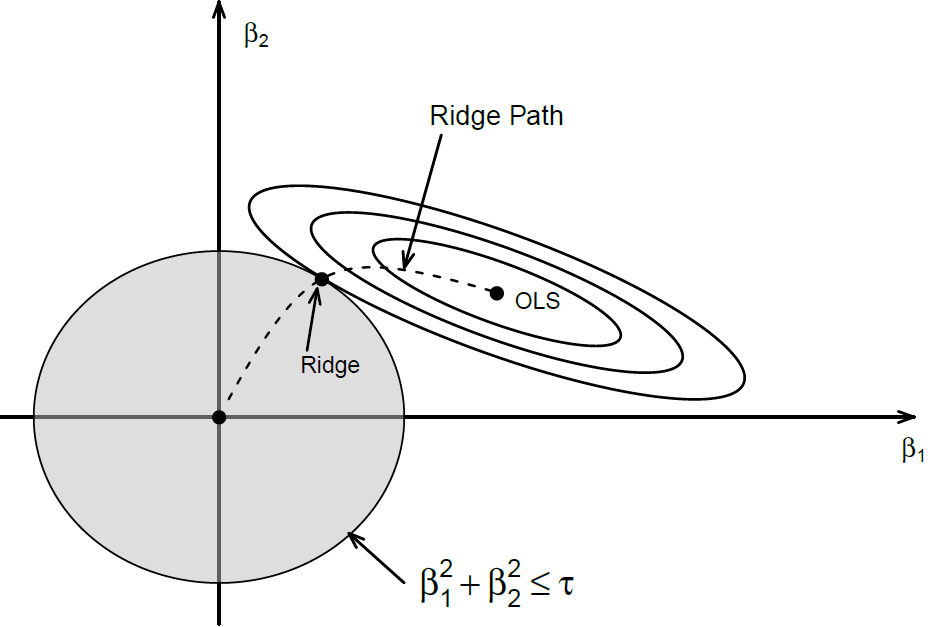

This figure help us visualize the constraint problem as it plots an example in $\mathbb{R}^2$. The constraint set $\mathbf{b}^\prime\mathbf{b}\le\tau$ is displayed as the ball about the origin and the contour sets of the $\mathrm{SSE}$ are displayed as ellipses. The least squares estimator is the center of the ellipses, while the ridge regression
estimator is the point on the circle where the contour is tangent. This shrinks the least squares coefficient towards the zero vector. It shrinks along a trajectory determined by the degree of correlation between the variables. This trajectory is displayed with the dashed lines, marked as 'Ridge path'. This is the sequence of ridge regression coefficients obtained as $\lambda$ (or $\tau$) is varied from small to large. When $\lambda=0$ (or $\tau$ is large) the ridge estimator equals least squares. For small $\lambda$ the ridge estimator moves slightly towards the origin by sliding along the ridge of the contour set. As $\lambda$ increases the ridge estimator takes a more direct path towards the origin.

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Real_coordinate_space" style="color: #cc0000">$\mathbb{R}^2$</a></p>

💻 In these set of commands the Ridge estimators are calculated for a sequence of values of $\lambda$ and we observe their performance

In [ ]:
## sequence of lambdas
lambda <- seq(0, 4, by = 0.5)

## Ridge regression with lambda=0
model <- glmnet(x.train, y.train, alpha = 0, lambda = lambda[1])
beta.hat <- coef(model)

## Ridge regression with lambda=.5,1,1.5,...,4
for (i in 2:length(lambda)) {
    model <- glmnet(x.train, y.train, alpha = 0, lambda = lambda[i])
    beta.hat <- cBind(beta.hat, coef(model))
}

par(mar = c(5, 5, 5, 5))
plot(lambda, beta.hat["rooms", ], las = 1, main = "Predictor: avg number of rooms per house", 
    ylab = expression(hat(beta)[ridge]), xlab = expression(lambda))

<ins>Selecting the Tuning Parameter</ins>

As it can be seen from the empirical example above the actual value of the tuning parameter $\lambda$ has an effect on the resulting $\widehat{\boldsymbol{\beta}}_{\text{ridge}}$ values. LOOCV provides a simple way to tackle this problem. We choose a grid of $\lambda$ values, and compute the LOOCV error for each value of $\lambda$. We then select the tuning parameter value for which the cross-validation error is the smallest. In this case the leave-one-out
ridge regression estimator, prediction errors, and CV criterion are

$$
\begin{aligned} \widehat{\boldsymbol{\beta}}_{-i}(\lambda) &=\left(\sum_{j \neq i} \mathbf{x}_{j} \mathbf{x}_{j}^{\prime}+\lambda\mathbf{I}_k\right)^{-1}\left(\sum_{j \neq i} \mathbf{x}_{j} y_{i}\right), \\ \widetilde{e}_{i}(\lambda) &=y_{i}-\mathbf{x}_{i}^{\prime} \widehat{\boldsymbol{\beta}}_{-i}, \\ \text{CV}(\lambda) &=\sum_{i=1}^{n} \widetilde{e}_{i}(\lambda)^{2}. \end{aligned}
$$

The CV-selected shrinkage parameter $\widehat{\lambda}$ minimizes $\mathrm{CV}(\lambda)$. The cross-validation ridge estimator is calculated using $\widehat{\lambda}$.

In [ ]:
## RIDGE: find the best lambda using LOOCV
set.seed(42)
cv <- cv.glmnet(x.train, y.train, alpha = 0, nfolds = length(y.train))

## RIDGE: display the best lambda value
cv$lambda.min

Finally, the model is re-fit using all the available observations and the selected value of the tuning parameter, i.e., $\widehat{\lambda}$.

In [ ]:
## RIDGE: fit the final model on the training data
model <- glmnet(x.train, y.train, alpha = 0, lambda = cv$lambda.min)

## RIDGE: display regression coefficients
coef(model)

One can then use the resulting model for prediction using the validation data set.

In [ ]:
## RIDGE: make predictions on the test data
predictions <- model %>% predict(x.test) %>% as.vector()

## RIDGE: model performance metrics
data.frame(RMSE = RMSE(predictions, test.data$lprice), Rsquare = R2(predictions, 
    test.data$lprice))

✍🏽 One disadvantage of the ridge regression is that, it will include _all_ the predictors in the final model. Ridge regression shrinks the coefficients towards zero, but it will not set any of them exactly to zero.

## _Lasso_ Regression

The LASSO stands for **Least Absolute Shrinkage and Selection Operator**. It shrinks the regression coefficients towards zero by penalizing the regression model with a $L_1$ penalty. The $L_{1}$ penalized least squares criterion is
$$
\begin{aligned} \mathrm{SSE}_{1}(\mathbf{b}, \lambda) &=(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda \sum_{j=1}^{k}\left|\beta_{j}\right| \\ &=\|\mathbf{y}-\mathbf{X} \mathbf{b}\|_{2}^{2}+\lambda\|\mathbf{b}\|_{1}, \end{aligned}
$$
where $\|\mathbf{a}\|_{1}=\sum_{j=1}^{k}\left|a_{j}\right|$ is the $L_{1}$-norm. The LASSO estimator is then defined as
$$
\widehat{\boldsymbol{\beta}}_{\text{lasso}}=\underset{\mathbf{b}}{\text{arg min }} \mathrm{SSE}_{1}(\mathbf{b}, \lambda).
$$

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Taxicab_geometry" style="color: #cc0000">$L_1$-norm</a></p>

***
The LASSO minimization problem has the dual constrained optimization problem
$$
\widehat{\boldsymbol{\beta}}_{\text {lasso }}=\underset{\|\beta\|_{1} \leq \tau}{\text{arg min } \mathrm{SSE}_1}(\mathbf{b}).
$$
To see that the two problems are the same observe that the constrained optimization problem has the Lagrangian
$$
\min _{\mathbf{b}}(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda\left(\sum_{j=1}^{k}\left|b_{j}\right|-\tau\right)
$$
which has first order conditions
$$
-2 \mathbf{x}_{j}^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda \text{ sgn}\left(b_{j}\right)=0
$$

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Sign_function" style="color: #cc0000">Sign Function</a></p>

which are the same as those for minimization of the penalized criterion. Thus the solutions are identical.

***

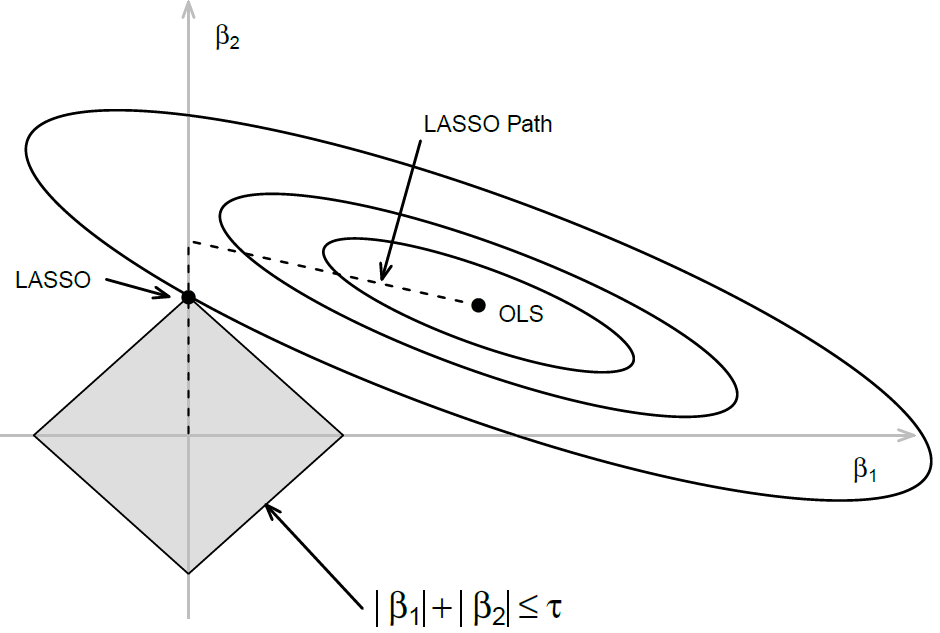

The constrained minimization problem in $\mathbb{R}^2$ is shown here. As one can see the constraint set $\left\{\|\mathbf{b}\|_{1} \leq \tau\right\}$ for the dual problem is a cross-polytope, resembling a multi-faceted diamond. As before the sum of squared error contour sets are the ellipses with the least squares solution at the center. The constraint set is the shaded polytope. The LASSO estimator is the intersection point between the constraint set and the largest ellipse drawn, and in this example hits a vertex of the constraint set, and so the constrained estimator sets $\widehat{\beta}_1=0$. This is a typical outcome in LASSO estimation. Since we are minimizing a quadratic subject to a polytope constraint, the solution tends to be at vertices which eliminate a subset of the coefficients.

The LASSO path is drawn with the dashed line. This is the sequence of solution paths obtained as the constraint set is varied. The solution path has the property that it is a straight line from the least squares estimator to the y-axis (in this example), at which point $\beta_1$ is set to zero, and then the solution path follows the y-axis to the origin. With a general number of coefficients the solution path has a similar property, where the solution path is linear on segments until each coefficient hits zero, at which point it is eliminated. In this particular example the solution path shows $\beta_2$ increasing while $\beta_1$ decreases. Thus while LASSO is a shrinkage estimator it does not necessarily shrink the individual coefficients monotonically.

💻 In these set of commands the Ridge estimators are calculated for a sequence of values of $\lambda$ and we observe their performance

In [ ]:
## sequence of lambdas
lambda <- seq(0, 4, by = 0.5)

## LASSO regression with lambda=0
model <- glmnet(x.train, y.train, alpha = 1, lambda = lambda[1])
beta.hat <- coef(model)

## LASSO regression with lambda=.5,1,1.5,...,4
for (i in 2:length(lambda)) {
    model <- glmnet(x.train, y.train, alpha = 1, lambda = lambda[i])
    beta.hat <- cBind(beta.hat, coef(model))
}

par(mar = c(5, 5, 5, 5))
plot(lambda, beta.hat["rooms", ], las = 1, main = "Predictor: avg number of rooms per house", 
    ylab = expression(hat(beta)[lasso]), xlab = expression(lambda))

<ins>Selecting the Tuning Parameter</ins>

Critically important for LASSO estimation is the choice of penalty $\lambda$. The most common choice is minimization of $k$-fold cross validation. Leave-one-out CV is not used as it is computationally expensive. $k$-fold is a computationally feasible substitute. Many programs set the default number of folds as $k=10$, though some authors use $k=5$, while others recommend $k=20$. It is common to find that the results of $k$-fold CV can be sensitive across runs (the methods depends on the random sorting of the observations).

In [ ]:
## LASSO: find the best lambda using k-fold (k=10) cross-validation
set.seed(42)
cv <- cv.glmnet(x.train, y.train, alpha = 1, nfold = 10)

## LASSO: display the best lambda value
cv$lambda.min

In [ ]:
## LASSO: fit the final model on the training data
model <- glmnet(x.train, y.train, alpha = 1, lambda = cv$lambda.min)

## LASSO: display regression coefficients
coef(model)

In [ ]:
## LASSO: make predictions on the test data
predictions <- model %>% predict(x.test) %>% as.vector()

## LASSO: model performance metrics
data.frame(RMSE = RMSE(predictions, test.data$lprice), Rsquare = R2(predictions, 
    test.data$lprice))

#### OLS vs Ridge vs LASSO: A Special Case

One case where we can explicitly calculate the LASSO estimates is when the regressors are orthogonal. Suppose that $\mathbf{X}^{\prime} \mathbf{X}=\mathbf{I}_{k}$ and $k<n$. Then the first order condition for minimization simplifies to

$$
-2\left(\widehat{\beta}_{\mathrm{ols}, j}-\widehat{\beta}_{\text{lasso}, j}\right)+\lambda \text{ sgn}\left(\widehat{\beta}_{\text{lasso}, j}\right)=0
$$

which has the explicit solution

$\widehat{\beta}_{\text {lasso, } j}=\left\{\begin{array}{ll}{\widehat{\beta}_{\text {ols, }, j}-\lambda / 2} & {\widehat{\beta}_{\text {ols, }, j}>\lambda / 2} \\ {0} & {\left|\widehat{\beta}_{\text {ols, }, j}\right| \leq \lambda / 2} \\ {\widehat{\beta}_{\text {ols, } j}+\lambda / 2} & {\widehat{\beta}_{\text {ols, } j}<-\lambda / 2}\end{array}\right.$


Similarly the ridge estimator equals

$$
\widehat{\boldsymbol{\beta}}_{\text {ridge}}=(1+\lambda)^{-1} \widehat{\boldsymbol{\beta}}_{\text {ols}}.
$$

✍🏽 For small values of the least squares estimate the LASSO estimate is set to zero. For all other values the LASSO
estimate moves the least squares estimate towards zero by $\lambda/2$.

✍🏽 The ridge estimate shrinks the coefficients towards zero by a common multiple.

## _Elastic Net_

The difference between LASSO and ridge regression is that the LASSO uses an $L_1$ penalty while ridge uses an $L_2$ penalty. Since the two procedures both have advantages it seems reasonable that further improvements can be obtained by taking a compromise between the two, i.e.,

$$
\mathrm{SSE}_3(\mathbf{b}, \lambda, \alpha)=(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda\left(\alpha\|\mathbf{b}\|_{2}^{2}+(1-\alpha)\|\mathbf{b}\|_{1}\right)
$$

for $0 < \alpha < 1$ and is called the **Elastic Net**. For $\alpha=0$ we obtain LASSO and for $\alpha=1$ we obtain ridge
regression. For small but positive $\alpha$ the constraint sets are similar to “rounded” versions of the LASSO constraint sets.

<ins>Selecting the Tuning Parameters</ins>

Typically the parameters $(\alpha,\lambda)$ are selected by joint minimization of the $k$-fold cross-validation criterion.

💻 In the following set of commands we will test the combiantion of 15 different values for $\alpha$ and $\lambda$. This is specified using the option ```tuneLength``` below. It will also perform 10-fold cross-validation.

In [ ]:
## ELASTIC: building the model
set.seed(42)
elastic <- train(lprice ~ ., data = data.frame(lprice = y.train, x.train), method = "glmnet", 
    trControl = trainControl("cv", number = 10), tuneLength = 15)

## ELASTIC: Best CV tuning parameters
elastic$bestTune

## ELASTIC: model coefficients
coef(elastic$finalModel, elastic$bestTune$lambda)

## ELASTIC: making predictions
predictions <- elastic %>% predict(data.frame(lprice = y.test, x.test))

## ELASTIC: model prediction performance
data.frame(RMSE = RMSE(predictions, test.data$lprice), Rsquare = R2(predictions, 
    test.data$lprice))

#### Ridge vs LASSO vs Elastic Net

💻 The ```caret``` package will automatically choose the best tuning parameter values, compute the final model, and evaluate the model performance using cross-validation techniques. We start by setting up a grid range of $\lambda$ values:

In [ ]:
## setting up a grid range of lambda values
lambda <- 10^seq(-3, 3, length = 100)

In [ ]:
## RIDGE: building the model
set.seed(42)
ridge <- train(lprice ~ ., data = data.frame(lprice = y.train, x.train), method = "glmnet", 
    trControl = trainControl("cv", number = 10), tuneGrid = expand.grid(alpha = 0, 
        lambda = lambda))

## RIDGE: model coefficients
coef(ridge$finalModel, ridge$bestTune$lambda)

## RIDGE: making predictions
predictions <- ridge %>% predict(data.frame(lprice = y.test, x.test))

## RIDGE: model prediction performance
data.frame(RMSE = RMSE(predictions, test.data$lprice), Rsquare = R2(predictions, 
    test.data$lprice))

In [ ]:
## LASSO: building the model
set.seed(42)
lasso <- train(lprice ~ ., data = data.frame(lprice = y.train, x.train), method = "glmnet", 
    trControl = trainControl("cv", number = 10), tuneGrid = expand.grid(alpha = 1, 
        lambda = lambda))

## LASSO: model coefficients
coef(lasso$finalModel, lasso$bestTune$lambda)

## LASSO: making predictions
predictions <- lasso %>% predict(data.frame(lprice = y.test, x.test))

## LASSO: model prediction performance
data.frame(RMSE = RMSE(predictions, test.data$lprice), Rsquare = R2(predictions, 
    test.data$lprice))

💻 The following set of commands identify the _best_ model in terms of the prediction error:

In [ ]:
models <- list(ridge = ridge, lasso = lasso, elastic = elastic)
resamples(models) %>% summary(metric = "RMSE")

💻 It seems that the LASSO model has the lowest median RMSE.